In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from typing import Dict, List
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras

In [ ]:
os.environ['KAGGLE_USERNAME'] = "hemadityaathota"
os.environ['KAGGLE_KEY'] = "cf0d5c3392b88c0a5994f9e4de69b062"

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge -f icml_face_data.csv
!unzip '/content/icml_face_data.csv.zip'
!rm '/content/icml_face_data.csv.zip'

 92% 89.0M/96.6M [00:01<00:00, 67.2MB/s]
100% 96.6M/96.6M [00:01<00:00, 76.9MB/s]
Archive:  /content/icml_face_data.csv.zip
  inflating: icml_face_data.csv      


In [ ]:
fer_df: pd.DataFrame = pd.read_csv('/content/icml_face_data.csv')
fer_df.columns = ["emotion", "Usage", "pixels"]

In [ ]:
fer_df.head(10)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


In [ ]:
fer_df.tail(10)

,emotion,Usage,pixels
35877,6,PrivateTest,139 143 145 154 159 168 176 181 190 191 195 19...
35878,3,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
35879,2,PrivateTest,0 0 6 16 19 31 47 18 26 19 17 8 15 3 4 2 14 20...
35880,2,PrivateTest,164 172 175 171 172 173 178 181 188 192 197 20...
35881,0,PrivateTest,181 177 176 156 178 144 136 132 122 107 131 16...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886,2,PrivateTest,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...


In [ ]:
fer_df: pd.DataFrame = fer_df.drop("Usage", axis=1)
fer_df.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


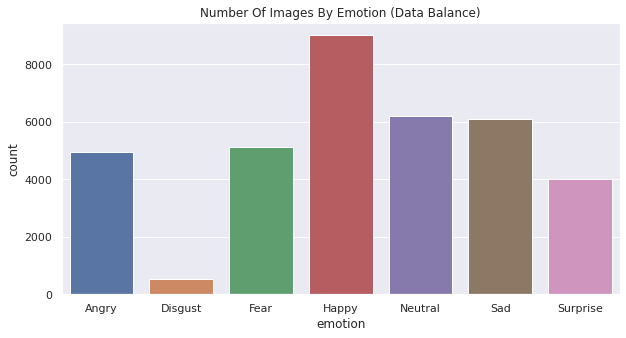

In [ ]:
emotion_map: Dict[int,str] = {0:"Angry", 1:"Disgust", 2:"Fear",
                              3:"Happy", 4:"Sad", 5:"Surprise",
                              6:"Neutral"}

emotion_labels: pd.DataFrame = fer_df["emotion"].apply(
    lambda x: emotion_map[x])

plt.figure(figsize=(10,5))
plt.title("Number Of Images By Emotion (Data Balance)")
sns.countplot(x=emotion_labels.sort_values())
plt.show()

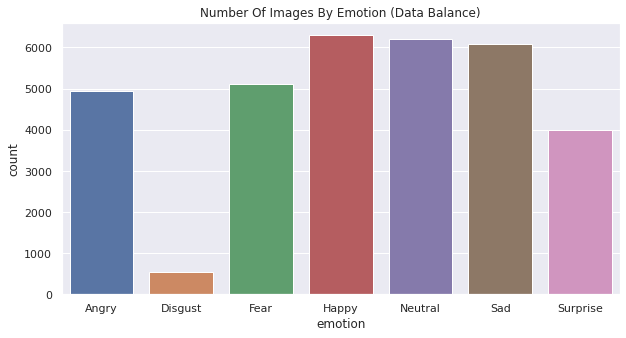

In [ ]:
happy_df: pd.DataFrame = fer_df[fer_df["emotion"] == 3].sample(
    frac=0.7, replace=True, random_state=42)

other_df: pd.DataFrame = fer_df[fer_df["emotion"] != 3]
fer_df: pd.DataFrame = pd.concat(
    [happy_df, other_df]).reset_index(drop=True)
emotion_labels: pd.DataFrame = fer_df["emotion"].apply(
    lambda x: emotion_map[x])

plt.figure(figsize=(10,5))
plt.title("Number Of Images By Emotion (Data Balance)")
sns.countplot(x=emotion_labels.sort_values())
plt.show()

In [ ]:
images: List[np.ndarray] = []
images_without_disgust: List[np.ndarray] = []
labels: List[int] = []
labels_without_disgust: List[int] = []


for index, row in fer_df.iterrows():
    image_arr: List[str] = row["pixels"].split(" ")
    image: np.ndarray = np.asarray(
        image_arr, dtype=np.float32).reshape((48, 48))
    images.append(image)
    labels.append(row["emotion"])

    if row["emotion"] != 1:
        images_without_disgust.append(image)
        if row["emotion"] != 0:
            labels_without_disgust.append(row["emotion"] - 1)
        else:
            labels_without_disgust.append(row["emotion"])

images: np.ndarray = np.asarray(images)
labels: np.ndarray  = np.asarray(labels)
images_without_disgust: np.ndarray = np.asarray(images_without_disgust)
labels_without_disgust: np.ndarray  = np.asarray(labels_without_disgust)

In [ ]:
print(f"Images shape: {images.shape}")
print(f"Labels shape: {images.shape}")
print(f"Images (without disgust) shape: {images_without_disgust.shape}")
print(f"Labels (without disgust) shape: {labels_without_disgust.shape}")

Images shape: (33190, 48, 48)
Labels shape: (33190, 48, 48)
Images (without disgust) shape: (32643, 48, 48)
Labels (without disgust) shape: (32643,)


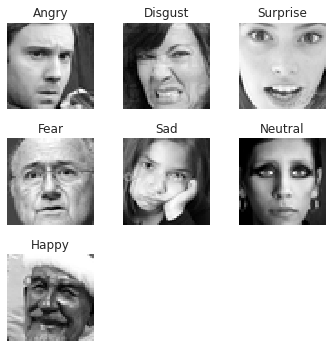

In [ ]:
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(3, 3, figsize=(5,5))
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

ax[0, 0].imshow(images[6292], cmap="gray", interpolation='nearest')
ax[0, 0].axis('off')
ax[0, 0].set_title(emotion_map[labels[6292]])

ax[0, 1].imshow(images[6590], cmap="gray", interpolation='nearest')
ax[0, 1].axis('off')
ax[0, 1].set_title(emotion_map[labels[6590]])

ax[0, 2].imshow(images[6312], cmap="gray", interpolation='nearest')
ax[0, 2].axis('off')
ax[0, 2].set_title(emotion_map[labels[6312]])

ax[1, 0].imshow(images[6297], cmap="gray", interpolation='nearest')
ax[1, 0].axis('off')
ax[1, 0].set_title(emotion_map[labels[6297]])

ax[1, 1].imshow(images[28945], cmap="gray", interpolation='nearest')
ax[1, 1].axis('off')
ax[1, 1].set_title(emotion_map[labels[28945]])

ax[1, 2].imshow(images[6296], cmap="gray", interpolation='nearest')
ax[1, 2].axis('off')
ax[1, 2].set_title(emotion_map[labels[6296]])

ax[2, 0].imshow(images[0], cmap="gray", interpolation='nearest')
ax[2, 0].axis('off')
ax[2, 0].set_title(emotion_map[labels[0]])

plt.tight_layout()
plt.show()

In [ ]:
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None

images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels)
x_train: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_train])
x_test: np.ndarray = np.asarray(
    [keras.applications.xception.preprocess_input(
        cv2.cvtColor(
            cv2.resize(img, (96,96)),
            cv2.COLOR_GRAY2RGB)) for img in images_test])

y_train = keras.utils.to_categorical(labels_train, 7)
y_test = keras.utils.to_categorical(labels_test, 7)

Next, we build the transfer learning model to predict our image labels.

As we can see, the model model architecture is:
- Input layer for 96 X 96 X 3 images.
- Augmentation layer - horizontal flip.
- Augmentation layer - rotation.
- Xception without its top layers (classification layers) - with trainable layers to allow fine tuning.
- Our classification layer.

In [ ]:
base_model: keras.Model = keras.applications.Xception(
    weights='imagenet', input_shape=(96, 96, 3),
    include_top=False, pooling='avg')

base_model.trainable = True

model: keras.Model = keras.models.Sequential(
    [
     keras.Input(shape=(96, 96, 3)),
     keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     base_model,
     keras.layers.Dropout(0.3),
     keras.layers.Dense(7, activation='softmax')
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_file_path = '/content/checkpoint'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history: keras.callbacks.History = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
664/664 [==============================] - 202s 294ms/step - loss: 1.6164 - accuracy: 0.3593 - val_loss: 1.4811 - val_accuracy: 0.4630
Epoch 2/30
664/664 [==============================] - 193s 291ms/step - loss: 1.2954 - accuracy: 0.5084 - val_loss: 1.4739 - val_accuracy: 0.4749
Epoch 3/30
664/664 [==============================] - 193s 291ms/step - loss: 1.2132 - accuracy: 0.5348 - val_loss: 1.2430 - val_accuracy: 0.5553
Epoch 4/30
664/664 [==============================] - 193s 291ms/step - loss: 1.1532 - accuracy: 0.5625 - val_loss: 1.1365 - val_accuracy: 0.5662
Epoch 5/30
664/664 [==============================] - 193s 291ms/step - loss: 1.0991 - accuracy: 0.5868 - val_loss: 1.1916 - val_accuracy: 0.5347
Epoch 6/30
664/664 [==============================] - 193s 290ms/step - loss: 1.0598 - accuracy: 0.6019 - val_loss: 1.0872 - val_accuracy: 0.5863
Epoch 7/30
664/664 [==============================] - 193s 291ms/step - loss: 1.0369 - accuracy: 0.6107 - val_loss: 1.0607 -

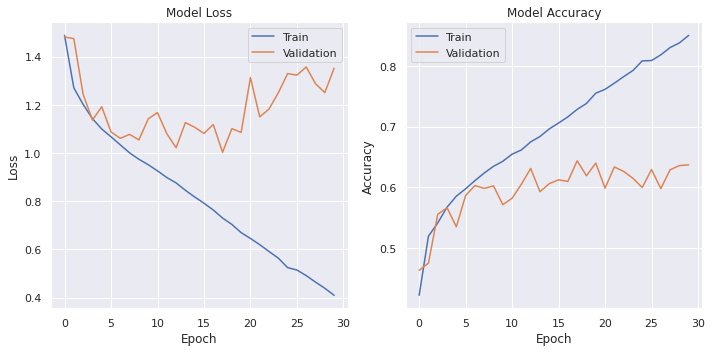

In [ ]:
fig: mpl.figure.Figure = None
ax: np.ndarray = None
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.load_weights(checkpoint_file_path)
model_eval: List[float] = model.evaluate(x_test, y_test)
print(f"Model loss: {model_eval[0]}\nModel accuracy {model_eval[1]}")

208/208 [==============================] - 15s 72ms/step - loss: 0.9822 - accuracy: 0.6485
Model loss: 0.9822131395339966
Model accuracy 0.6485387086868286


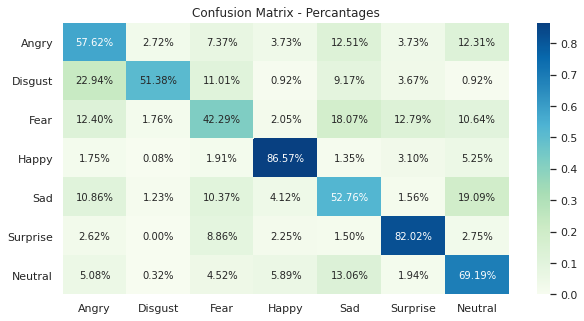

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
cm_array = confusion_matrix(np.argmax(y_test, axis=-1), y_pred,
                            normalize='true')
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percantages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()